In [1]:
import anndata as ad
import gc
import sys
from scipy.sparse import csc_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression
import random
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import pickle
import heapq
import matplotlib
import os

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

batch_size = 50000
pred_num = 1

cuda


In [3]:
train_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod1.h5ad'
train_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod2.h5ad'
test_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod1.h5ad'
test_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod2.h5ad'

In [4]:
input_train_mod1 = ad.read_h5ad(train_mod1_file)
input_train_mod2 = ad.read_h5ad(train_mod2_file)
input_test_mod1 = ad.read_h5ad(test_mod1_file)
input_test_mod2 = ad.read_h5ad(test_mod2_file)

In [5]:
print(input_train_mod1)
print(input_train_mod2)
print(input_test_mod1)
print(input_test_mod2)

AnnData object with n_obs × n_vars = 66175 × 13953
    obs: 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 66175 × 134
    obs: 'batch', 'size_factors'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 13953
    obs: 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 134
    obs: 'batch', 'size_factors'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'


In [6]:
print(sorted(set(input_train_mod1.obs['batch'])))
print(sorted(set(input_train_mod2.obs['batch'])))

['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']
['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']


In [7]:
print(sorted(set(input_test_mod1.obs['batch'])))
print(sorted(set(input_test_mod2.obs['batch'])))

['s4d1', 's4d8', 's4d9']
['s4d1', 's4d8', 's4d9']


In [8]:
RNA_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :]
RNA_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :]
RNA_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :]
RNA_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :]
RNA_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :]
RNA_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :]

RNA_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :]
RNA_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :]
RNA_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :]

In [9]:
pro_s1d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d1", :]
pro_s1d2 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d2", :]
pro_s1d3 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d3", :]
pro_s2d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d1", :]
pro_s2d4 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d4", :]
pro_s2d5 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d5", :]

pro_s3d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d1", :]
pro_s3d6 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d6", :]
pro_s3d7 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d7", :]

In [10]:
RNA_s4d1 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d1", :]
RNA_s4d8 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d8", :]
RNA_s4d9 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d9", :]

In [11]:
pro_s4d1 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d1", :]
pro_s4d8 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d8", :]
pro_s4d9 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d9", :]

In [12]:
RNA_s1d1 = RNA_s1d1.X.toarray()
RNA_s1d2 = RNA_s1d2.X.toarray()
RNA_s1d3 = RNA_s1d3.X.toarray()
RNA_s2d1 = RNA_s2d1.X.toarray()
RNA_s2d4 = RNA_s2d4.X.toarray()
RNA_s2d5 = RNA_s2d5.X.toarray()

RNA_s3d1 = RNA_s3d1.X.toarray()
RNA_s3d6 = RNA_s3d6.X.toarray()
RNA_s3d7 = RNA_s3d7.X.toarray()

In [13]:
pro_s1d1 = pro_s1d1.X.toarray()
pro_s1d2 = pro_s1d2.X.toarray()
pro_s1d3 = pro_s1d3.X.toarray()
pro_s2d1 = pro_s2d1.X.toarray()
pro_s2d4 = pro_s2d4.X.toarray()
pro_s2d5 = pro_s2d5.X.toarray()

pro_s3d1 = pro_s3d1.X.toarray()
pro_s3d6 = pro_s3d6.X.toarray()
pro_s3d7 = pro_s3d7.X.toarray()

In [14]:
RNA_s4d1 = RNA_s4d1.X.toarray()
RNA_s4d8 = RNA_s4d8.X.toarray()
RNA_s4d9 = RNA_s4d9.X.toarray()

In [15]:
pro_s4d1 = pro_s4d1.X.toarray()
pro_s4d8 = pro_s4d8.X.toarray()
pro_s4d9 = pro_s4d9.X.toarray()

In [16]:
print(RNA_s1d1.shape)
print(pro_s1d1.shape)

(4721, 13953)
(4721, 134)


In [17]:
print(RNA_s4d1.shape)
print(pro_s4d1.shape)

(334, 13953)
(334, 134)


In [18]:
batch_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :].obs["batch"]
batch_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :].obs["batch"]
batch_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :].obs["batch"]
batch_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :].obs["batch"]
batch_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :].obs["batch"]
batch_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :].obs["batch"]

batch_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :].obs["batch"]
batch_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :].obs["batch"]
batch_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :].obs["batch"]

batch_s4d1 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d1", :].obs["batch"]
batch_s4d8 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d8", :].obs["batch"]
batch_s4d9 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d9", :].obs["batch"]

In [19]:
batch_train = list(batch_s1d1)+list(batch_s1d2)+list(batch_s1d3)+list(batch_s2d1)+list(batch_s2d4)+list(batch_s2d5)
batch_val = list(batch_s3d1)+list(batch_s3d6)+list(batch_s3d7)
batch_test = list(batch_s4d1)+list(batch_s4d8)+list(batch_s4d9)

In [20]:
train_input = [RNA_s1d1, RNA_s1d2, RNA_s1d3, RNA_s2d1, RNA_s2d4, RNA_s2d5]
train_output = [pro_s1d1, pro_s1d2, pro_s1d3, pro_s2d1, pro_s2d4, pro_s2d5]

val_input = [RNA_s3d1, RNA_s3d6, RNA_s3d7]
val_output = [pro_s3d1, pro_s3d6, pro_s3d7]

test_input = [RNA_s4d1, RNA_s4d8, RNA_s4d9]
test_output = [pro_s4d1, pro_s4d8, pro_s4d9]

In [21]:
# # standardize based on each batch
# for i in range(len(train_input)):
#     train_input[i] = (train_input[i]-np.mean(train_input[i]))/np.std(train_input[i])

# for i in range(len(train_output)):
#     train_output[i] = (train_output[i]-np.mean(train_output[i]))/np.std(train_output[i])

# for i in range(len(val_input)):
#     val_input[i] = (val_input[i]-np.mean(val_input[i]))/np.std(val_input[i])

# for i in range(len(val_output)):
#     val_output[i] = (val_output[i]-np.mean(val_output[i]))/np.std(val_output[i])

In [22]:
train_input = train_input + val_input
train_output = train_output + val_output

In [23]:
train_input = np.concatenate(train_input, axis=0)
val_input = np.concatenate(val_input, axis=0)
test_input = np.concatenate(test_input, axis=0)

train_output = np.concatenate(train_output, axis=0)
val_output = np.concatenate(val_output, axis=0)
test_output = np.concatenate(test_output, axis=0)

In [24]:
# train_input = (train_input - np.reshape(np.mean(train_input, 1), (train_input.shape[0], 1)))/np.reshape(np.std(train_input, 1), (train_input.shape[0], 1))
# val_input = (val_input - np.reshape(np.mean(val_input, 1), (val_input.shape[0], 1)))/np.reshape(np.std(val_input, 1), (val_input.shape[0], 1))
# test_input = (test_input - np.reshape(np.mean(test_input, 1), (test_input.shape[0], 1)))/np.reshape(np.std(test_input, 1), (test_input.shape[0], 1))

In [25]:
train_input = torch.from_numpy(train_input)
train_output = torch.from_numpy(train_output)
val_input = torch.from_numpy(val_input)
val_output = torch.from_numpy(val_output)
test_input = torch.from_numpy(test_input)
test_output = torch.from_numpy(test_output)

In [26]:
train_input = train_input.float()
train_output = train_output.float()
val_input = val_input.float()
val_output = val_output.float()
test_input = test_input.float()
test_output = test_output.float()

In [27]:
train_input = train_input.to(device)
train_output = train_output.to(device)
val_input = val_input.to(device)
val_output = val_output.to(device)
test_input = test_input.to(device)
test_output = test_output.to(device)

In [28]:
colors = ['red','green','blue','purple', 'yellow', 'orange']
k = 0
batch_lib = {}
for i in range(len(batch_train)):
    if batch_train[i] not in batch_lib:
        k = k + 1
        batch_lib[batch_train[i]] = k
    batch_train[i] = batch_lib[batch_train[i]]

In [29]:
colors = ['red','green','blue','purple', 'yellow', 'orange']
k = 0
batch_lib = {}
for i in range(len(batch_val)):
    if batch_val[i] not in batch_lib:
        k = k + 1
        batch_lib[batch_val[i]] = k
    batch_val[i] = batch_lib[batch_val[i]]

In [30]:
colors = ['red','green','blue','purple', 'yellow', 'orange']
k = 0
batch_lib = {}
for i in range(len(batch_test)):
    if batch_test[i] not in batch_lib:
        k = k + 1
        batch_lib[batch_test[i]] = k
    batch_test[i] = batch_lib[batch_test[i]]

In [31]:
batch_train = batch_train + batch_val

In [32]:
train_output = train_output[:, 0:pred_num]
train_output.shape

torch.Size([66175, 1])

In [33]:
val_output = val_output[:, 0:pred_num]
val_output.shape

torch.Size([28921, 1])

In [34]:
test_output = test_output[:, 0:pred_num]
test_output.shape

torch.Size([1000, 1])

In [35]:
train_ds = TensorDataset(train_input, train_output)
train_dl = DataLoader(train_ds, batch_size= batch_size, shuffle=True)

In [36]:
input_feature = train_input.shape[1]
output_feature = pred_num

In [42]:
# auto-encoder model
# base model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.linear1 = nn.Linear(input_feature, latent_dim)
        self.linear2 = nn.Linear(input_feature//2, input_feature//4)
        self.linear3 = nn.Linear(input_feature//4, input_feature//8)
        self.linear4 = nn.Linear(input_feature//8, input_feature//16)
        
        self.linear5 = nn.Linear(latent_dim, pred_num)
        self.relu = nn.ReLU()
        self.leakyrelu = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout(0.15)
        
        self.linear = nn.Linear(input_feature, pred_num)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
#         x = self.linear2(x)
#         x = self.relu(x)
#         x = self.dropout(x)
        
#         x = self.linear3(x)
#         x = self.relu(x)
        
#         x = self.linear4(x)
#         x = self.relu(x)
        
        output = self.linear5(x)
        
        return output.float()

In [38]:
PATH = 'No_norm_model_RNA_pro_latent'

In [39]:
def fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output, test_input, test_output):
    # plt.rcParams['figure.figsize'] = [40, 40]
    val_best = float('inf')
    train_pred_output = []
    val_pred_output = []
    for epoch in range(num_epochs):
        for x,y in train_dl:
            model = model.train()
            pred = model(x)
            # print(y.shape, pred.shape)
            # y = torch.reshape(y, (y.shape[0], 1))
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()
            opt.zero_grad()

        if epoch % 100 == 0:
            model = model.eval()
            
            train_pred = model(train_input)
            # train_output = torch.reshape(train_output, (train_output.shape[0], 1))
            train_loss = loss_fn(train_pred, train_output)
            train_loss = torch.sqrt(train_loss)
            train_loss = train_loss.cpu().detach().numpy()
            
            val_pred = model(val_input)
            # val_output = torch.reshape(val_output, (val_output.shape[0], 1))
            val_loss = loss_fn(val_pred, val_output)
            val_loss = torch.sqrt(val_loss)
            val_loss = val_loss.cpu().detach().numpy()
            
            test_pred = model(test_input)
            # val_output = torch.reshape(val_output, (val_output.shape[0], 1))
            test_loss = loss_fn(test_pred, test_output)
            test_loss = torch.sqrt(test_loss)
            test_loss = test_loss.cpu().detach().numpy()
            
            if val_loss < val_best:
                torch.save(model.state_dict(), PATH)
                val_best = val_loss
                
            print('Epoch ', epoch, 'Train_loss: ', train_loss, ' Validation_loss: ', val_loss, ' Test_loss: ', test_loss)
        if epoch % 1000 == 0:
            colors = ['red','green','blue','purple', 'yellow', 'orange']
            figure, ax = plt.subplots(1, 3, figsize = (10, 4*1))
            for i in range(1):
                ax[0].scatter(train_output.cpu().detach().numpy()[:, 0], train_pred.cpu().detach().numpy()[:, 0], c=batch_train, cmap=matplotlib.colors.ListedColormap(colors), s = 30, alpha=0.3)
                ax[0].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[0].set_title('Train data result ' + str(i+1))
                ax[0].set_xlabel('train')
                ax[0].set_ylabel('pred')

                ax[1].scatter(val_output.cpu().detach().numpy()[:, 0], val_pred.cpu().detach().numpy()[:, 0], c=batch_val, cmap=matplotlib.colors.ListedColormap(colors), s = 30, alpha=0.3)
                ax[1].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[1].set_title('Validation data result ' + str(i+1))
                ax[1].set_xlabel('true')
                ax[1].set_ylabel('pred')

                ax[2].scatter(test_output.cpu().detach().numpy()[:, 0], test_pred.cpu().detach().numpy()[:, 0], c=batch_test, cmap=matplotlib.colors.ListedColormap(colors), s = 30, alpha=0.3)
                ax[2].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[2].set_title('Test data result ' + str(i+1))
                ax[2].set_xlabel('true')
                ax[2].set_ylabel('pred')
            
            plt.show()
            # train_pred_output.append([train_pred.cpu().detach().numpy(), train_output.cpu().detach().numpy()])
            # val_pred_output.append([val_pred.cpu().detach().numpy(), val_output.cpu().detach().numpy()])
    return train_pred.cpu().detach().numpy(), train_output.cpu().detach().numpy(), val_pred.cpu().detach().numpy(), val_output.cpu().detach().numpy()

Epoch  0 Train_loss:  0.3465369  Validation_loss:  0.2813115  Test_loss:  0.34385586


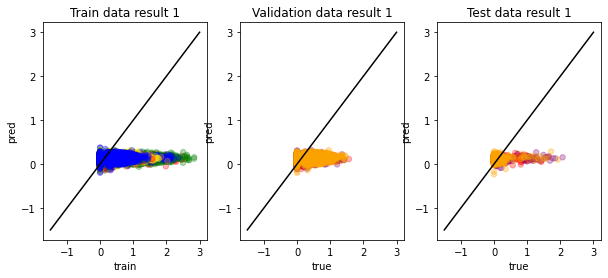

Epoch  100 Train_loss:  0.2180212  Validation_loss:  0.21338859  Test_loss:  0.20381215
Epoch  200 Train_loss:  0.20881493  Validation_loss:  0.20747705  Test_loss:  0.19153821
Epoch  300 Train_loss:  0.2037475  Validation_loss:  0.20388879  Test_loss:  0.18503495
Epoch  400 Train_loss:  0.20030567  Validation_loss:  0.20119433  Test_loss:  0.18160048
Epoch  500 Train_loss:  0.19772632  Validation_loss:  0.1990527  Test_loss:  0.17945552
Epoch  600 Train_loss:  0.19559726  Validation_loss:  0.1973537  Test_loss:  0.17813805
Epoch  700 Train_loss:  0.19382629  Validation_loss:  0.19588257  Test_loss:  0.17704469
Epoch  800 Train_loss:  0.19219567  Validation_loss:  0.19464608  Test_loss:  0.17635989
Epoch  900 Train_loss:  0.1907675  Validation_loss:  0.1935226  Test_loss:  0.17576653
Epoch  1000 Train_loss:  0.18944634  Validation_loss:  0.19251467  Test_loss:  0.17533432


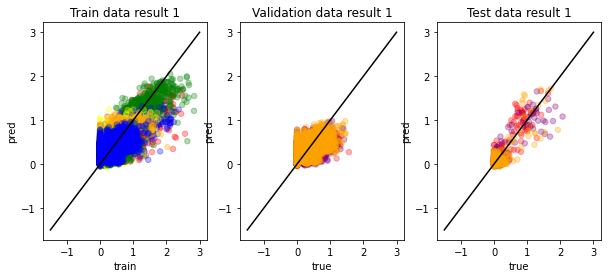

Epoch  1100 Train_loss:  0.18814735  Validation_loss:  0.19159013  Test_loss:  0.17529851
Epoch  1200 Train_loss:  0.18697415  Validation_loss:  0.19070214  Test_loss:  0.17495903
Epoch  1300 Train_loss:  0.18580157  Validation_loss:  0.18985236  Test_loss:  0.1748892
Epoch  1400 Train_loss:  0.18464492  Validation_loss:  0.18902613  Test_loss:  0.17520972
Epoch  1500 Train_loss:  0.18357004  Validation_loss:  0.18822853  Test_loss:  0.1750638
Epoch  1600 Train_loss:  0.18250453  Validation_loss:  0.18744455  Test_loss:  0.17523177
Epoch  1700 Train_loss:  0.18149199  Validation_loss:  0.18665692  Test_loss:  0.17516097
Epoch  1800 Train_loss:  0.18042253  Validation_loss:  0.18587966  Test_loss:  0.17558405
Epoch  1900 Train_loss:  0.17947482  Validation_loss:  0.18511271  Test_loss:  0.17527941
Epoch  2000 Train_loss:  0.17843685  Validation_loss:  0.1843389  Test_loss:  0.17578067


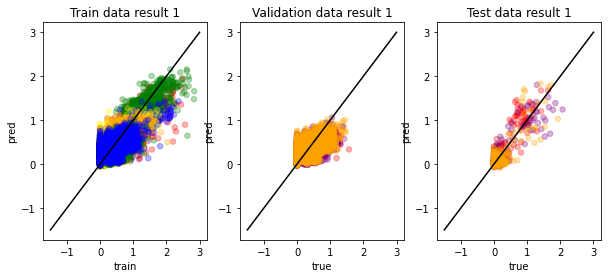

Epoch  2100 Train_loss:  0.17742209  Validation_loss:  0.18357459  Test_loss:  0.17632885
Epoch  2200 Train_loss:  0.17648342  Validation_loss:  0.18279912  Test_loss:  0.17614271
Epoch  2300 Train_loss:  0.17547733  Validation_loss:  0.18204576  Test_loss:  0.17692842
Epoch  2400 Train_loss:  0.17455825  Validation_loss:  0.18125995  Test_loss:  0.17684254
Epoch  2500 Train_loss:  0.17357984  Validation_loss:  0.18049264  Test_loss:  0.17754826
Epoch  2600 Train_loss:  0.17266864  Validation_loss:  0.17972612  Test_loss:  0.17767595
Epoch  2700 Train_loss:  0.17172842  Validation_loss:  0.17896314  Test_loss:  0.17798334
Epoch  2800 Train_loss:  0.17075707  Validation_loss:  0.17819846  Test_loss:  0.17898324
Epoch  2900 Train_loss:  0.16988592  Validation_loss:  0.17740965  Test_loss:  0.17873247
Epoch  3000 Train_loss:  0.16893236  Validation_loss:  0.17663011  Test_loss:  0.17940684


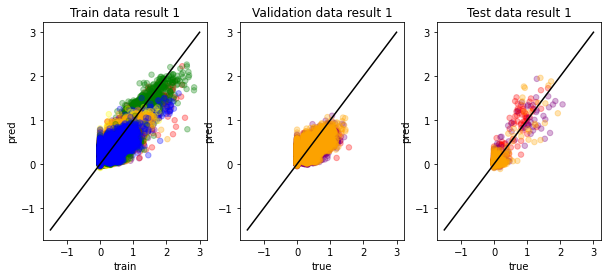

Epoch  3100 Train_loss:  0.16804105  Validation_loss:  0.17585786  Test_loss:  0.17971864
Epoch  3200 Train_loss:  0.16711614  Validation_loss:  0.175062  Test_loss:  0.18025684
Epoch  3300 Train_loss:  0.16623244  Validation_loss:  0.17429075  Test_loss:  0.18045512
Epoch  3400 Train_loss:  0.16527238  Validation_loss:  0.17348465  Test_loss:  0.18162218
Epoch  3500 Train_loss:  0.16437621  Validation_loss:  0.17269492  Test_loss:  0.18207076
Epoch  3600 Train_loss:  0.16348356  Validation_loss:  0.17189395  Test_loss:  0.1823299
Epoch  3700 Train_loss:  0.16260992  Validation_loss:  0.17111607  Test_loss:  0.18271829
Epoch  3800 Train_loss:  0.16169913  Validation_loss:  0.170302  Test_loss:  0.18342632
Epoch  3900 Train_loss:  0.16076407  Validation_loss:  0.16948847  Test_loss:  0.1844392
Epoch  4000 Train_loss:  0.15989856  Validation_loss:  0.16869639  Test_loss:  0.18471046


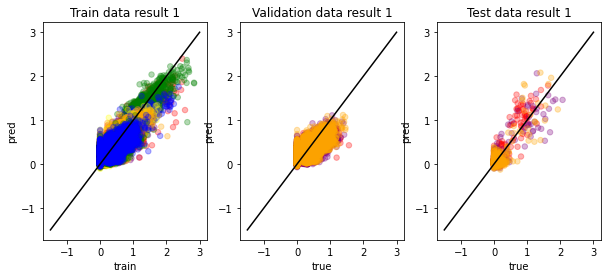

Epoch  4100 Train_loss:  0.15897752  Validation_loss:  0.16787541  Test_loss:  0.18550457
Epoch  4200 Train_loss:  0.15809579  Validation_loss:  0.16707523  Test_loss:  0.1860214
Epoch  4300 Train_loss:  0.15722202  Validation_loss:  0.16625297  Test_loss:  0.18636325
Epoch  4400 Train_loss:  0.1563341  Validation_loss:  0.16543743  Test_loss:  0.18695742
Epoch  4500 Train_loss:  0.15545365  Validation_loss:  0.16461752  Test_loss:  0.18758734
Epoch  4600 Train_loss:  0.15465301  Validation_loss:  0.16381918  Test_loss:  0.1875117
Epoch  4700 Train_loss:  0.15369269  Validation_loss:  0.16298431  Test_loss:  0.18899125
Epoch  4800 Train_loss:  0.1529124  Validation_loss:  0.16216743  Test_loss:  0.1885557
Epoch  4900 Train_loss:  0.15194982  Validation_loss:  0.16132015  Test_loss:  0.18986568
Epoch  5000 Train_loss:  0.15114407  Validation_loss:  0.16050014  Test_loss:  0.18970811


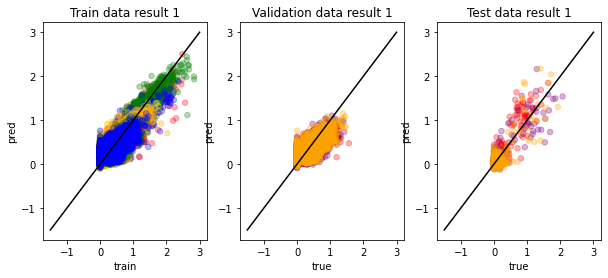

Epoch  5100 Train_loss:  0.15023243  Validation_loss:  0.15965986  Test_loss:  0.19077893
Epoch  5200 Train_loss:  0.14936788  Validation_loss:  0.15882686  Test_loss:  0.19135724
Epoch  5300 Train_loss:  0.14856908  Validation_loss:  0.15800947  Test_loss:  0.19136962
Epoch  5400 Train_loss:  0.14766017  Validation_loss:  0.15716851  Test_loss:  0.19204609
Epoch  5500 Train_loss:  0.14672567  Validation_loss:  0.1563082  Test_loss:  0.1934457
Epoch  5600 Train_loss:  0.14592625  Validation_loss:  0.15548754  Test_loss:  0.19323608
Epoch  5700 Train_loss:  0.14507508  Validation_loss:  0.15464893  Test_loss:  0.1936732
Epoch  5800 Train_loss:  0.14417988  Validation_loss:  0.15379909  Test_loss:  0.19452575
Epoch  5900 Train_loss:  0.14327733  Validation_loss:  0.15296075  Test_loss:  0.19570349
Epoch  6000 Train_loss:  0.14247322  Validation_loss:  0.15210965  Test_loss:  0.19543691


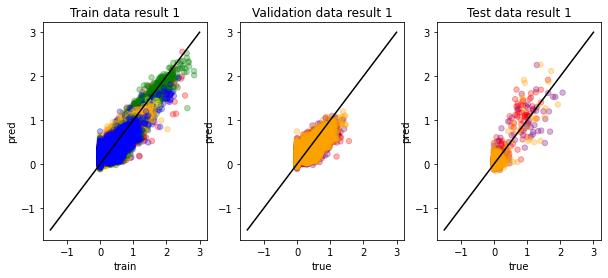

Epoch  6100 Train_loss:  0.14160815  Validation_loss:  0.151267  Test_loss:  0.19605139
Epoch  6200 Train_loss:  0.1407852  Validation_loss:  0.15043627  Test_loss:  0.19631054
Epoch  6300 Train_loss:  0.13988623  Validation_loss:  0.14956415  Test_loss:  0.19722912
Epoch  6400 Train_loss:  0.13900392  Validation_loss:  0.1487148  Test_loss:  0.19803062
Epoch  6500 Train_loss:  0.13814919  Validation_loss:  0.14787422  Test_loss:  0.19872957
Epoch  6600 Train_loss:  0.1373212  Validation_loss:  0.14702068  Test_loss:  0.19885616
Epoch  6700 Train_loss:  0.13649012  Validation_loss:  0.14617956  Test_loss:  0.19923241
Epoch  6800 Train_loss:  0.13562655  Validation_loss:  0.14537807  Test_loss:  0.2007303
Epoch  6900 Train_loss:  0.13483757  Validation_loss:  0.14452152  Test_loss:  0.20015587
Epoch  7000 Train_loss:  0.13395761  Validation_loss:  0.14365414  Test_loss:  0.20094477


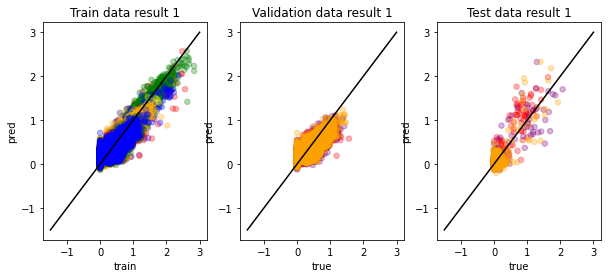

Epoch  7100 Train_loss:  0.13313201  Validation_loss:  0.14281835  Test_loss:  0.20135532
Epoch  7200 Train_loss:  0.13234596  Validation_loss:  0.14199074  Test_loss:  0.20146732
Epoch  7300 Train_loss:  0.13149619  Validation_loss:  0.14113489  Test_loss:  0.20213164
Epoch  7400 Train_loss:  0.13066225  Validation_loss:  0.1402914  Test_loss:  0.20255932
Epoch  7500 Train_loss:  0.12991992  Validation_loss:  0.13949502  Test_loss:  0.20248562
Epoch  7600 Train_loss:  0.12898071  Validation_loss:  0.13859837  Test_loss:  0.20383935
Epoch  7700 Train_loss:  0.12825313  Validation_loss:  0.13781404  Test_loss:  0.20368199
Epoch  7800 Train_loss:  0.1273604  Validation_loss:  0.13695182  Test_loss:  0.20474166
Epoch  7900 Train_loss:  0.12651685  Validation_loss:  0.13610715  Test_loss:  0.20543228
Epoch  8000 Train_loss:  0.12571362  Validation_loss:  0.13529122  Test_loss:  0.20598775


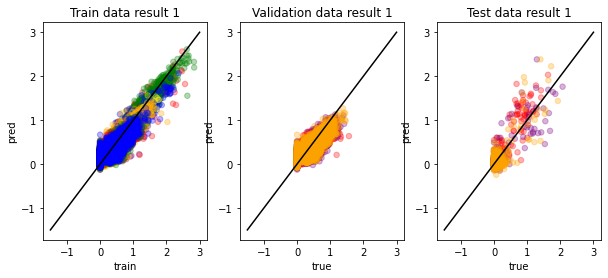

Epoch  8100 Train_loss:  0.12500678  Validation_loss:  0.13451529  Test_loss:  0.20552249
Epoch  8200 Train_loss:  0.12419261  Validation_loss:  0.13366514  Test_loss:  0.20600508
Epoch  8300 Train_loss:  0.1234796  Validation_loss:  0.13289458  Test_loss:  0.20615551
Epoch  8400 Train_loss:  0.12255013  Validation_loss:  0.13200404  Test_loss:  0.20737147
Epoch  8500 Train_loss:  0.12181597  Validation_loss:  0.13122314  Test_loss:  0.2073472
Epoch  8600 Train_loss:  0.12096437  Validation_loss:  0.13037333  Test_loss:  0.20795245
Epoch  8700 Train_loss:  0.120210364  Validation_loss:  0.12957364  Test_loss:  0.2082943
Epoch  8800 Train_loss:  0.11939646  Validation_loss:  0.12875135  Test_loss:  0.20915335
Epoch  8900 Train_loss:  0.11861007  Validation_loss:  0.12794822  Test_loss:  0.20946515
Epoch  9000 Train_loss:  0.11782942  Validation_loss:  0.12712514  Test_loss:  0.20992437


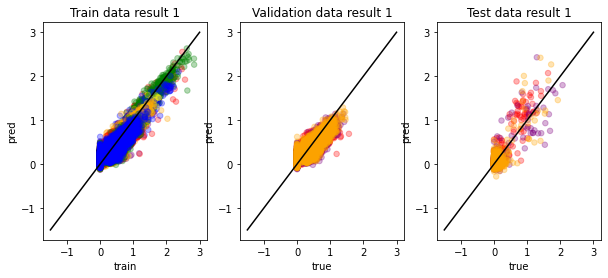

Epoch  9100 Train_loss:  0.11713527  Validation_loss:  0.12636872  Test_loss:  0.20975932
Epoch  9200 Train_loss:  0.116303205  Validation_loss:  0.12554334  Test_loss:  0.21067037
Epoch  9300 Train_loss:  0.11557006  Validation_loss:  0.12477666  Test_loss:  0.21088374
Epoch  9400 Train_loss:  0.11474222  Validation_loss:  0.1239501  Test_loss:  0.2119204
Epoch  9500 Train_loss:  0.11399691  Validation_loss:  0.123157196  Test_loss:  0.21230046
Epoch  9600 Train_loss:  0.11332979  Validation_loss:  0.122428216  Test_loss:  0.21191491
Epoch  9700 Train_loss:  0.11258601  Validation_loss:  0.12165421  Test_loss:  0.2122107
Epoch  9800 Train_loss:  0.11176265  Validation_loss:  0.12083378  Test_loss:  0.21334985
Epoch  9900 Train_loss:  0.111066006  Validation_loss:  0.12006755  Test_loss:  0.21317936
Epoch  10000 Train_loss:  0.11030306  Validation_loss:  0.11928925  Test_loss:  0.21390131


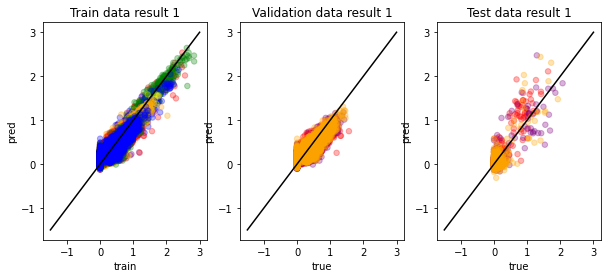

Epoch  10100 Train_loss:  0.109647796  Validation_loss:  0.118568316  Test_loss:  0.21351078
Epoch  10200 Train_loss:  0.108873054  Validation_loss:  0.11778767  Test_loss:  0.21428855
Epoch  10300 Train_loss:  0.108107634  Validation_loss:  0.11702308  Test_loss:  0.2151592
Epoch  10400 Train_loss:  0.10739377  Validation_loss:  0.11625779  Test_loss:  0.21541491
Epoch  10500 Train_loss:  0.10668839  Validation_loss:  0.11553286  Test_loss:  0.2156563
Epoch  10600 Train_loss:  0.10604411  Validation_loss:  0.11480977  Test_loss:  0.21551622
Epoch  10700 Train_loss:  0.105306886  Validation_loss:  0.114056036  Test_loss:  0.21585408
Epoch  10800 Train_loss:  0.104629666  Validation_loss:  0.11335274  Test_loss:  0.21611068
Epoch  10900 Train_loss:  0.10388356  Validation_loss:  0.11256072  Test_loss:  0.21664074
Epoch  11000 Train_loss:  0.10319519  Validation_loss:  0.111843444  Test_loss:  0.21698405


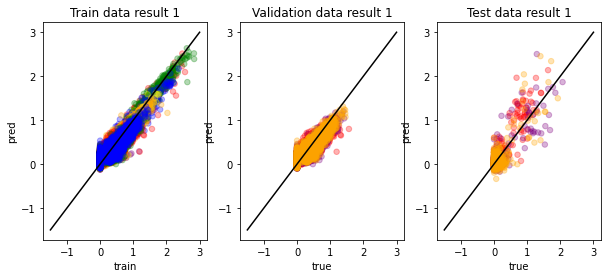

Epoch  11100 Train_loss:  0.10259828  Validation_loss:  0.11117776  Test_loss:  0.21687795
Epoch  11200 Train_loss:  0.10181321  Validation_loss:  0.11038847  Test_loss:  0.21749558
Epoch  11300 Train_loss:  0.101239525  Validation_loss:  0.109757684  Test_loss:  0.21736021
Epoch  11400 Train_loss:  0.10049308  Validation_loss:  0.1089944  Test_loss:  0.21799463
Epoch  11500 Train_loss:  0.09983512  Validation_loss:  0.10827954  Test_loss:  0.21829285
Epoch  11600 Train_loss:  0.0990885  Validation_loss:  0.10755821  Test_loss:  0.21951342
Epoch  11700 Train_loss:  0.09844512  Validation_loss:  0.10692233  Test_loss:  0.22060104
Epoch  11800 Train_loss:  0.09780948  Validation_loss:  0.10616443  Test_loss:  0.21958402
Epoch  11900 Train_loss:  0.09715551  Validation_loss:  0.105500326  Test_loss:  0.21994631
Epoch  12000 Train_loss:  0.09652152  Validation_loss:  0.10482668  Test_loss:  0.22010644


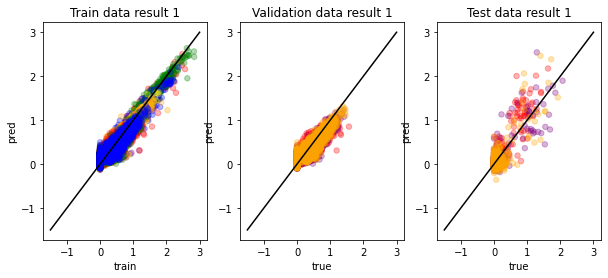

Epoch  12100 Train_loss:  0.095872216  Validation_loss:  0.104136996  Test_loss:  0.22046502
Epoch  12200 Train_loss:  0.095189065  Validation_loss:  0.103434354  Test_loss:  0.22096843
Epoch  12300 Train_loss:  0.09463084  Validation_loss:  0.10279596  Test_loss:  0.22064815
Epoch  12400 Train_loss:  0.09399583  Validation_loss:  0.102135375  Test_loss:  0.22107416
Epoch  12500 Train_loss:  0.09339684  Validation_loss:  0.10148036  Test_loss:  0.22126581
Epoch  12600 Train_loss:  0.09277861  Validation_loss:  0.10082152  Test_loss:  0.22134216
Epoch  12700 Train_loss:  0.092101194  Validation_loss:  0.10013886  Test_loss:  0.22194295
Epoch  12800 Train_loss:  0.09172724  Validation_loss:  0.09965827  Test_loss:  0.22123808
Epoch  12900 Train_loss:  0.09091541  Validation_loss:  0.0988808  Test_loss:  0.22225964
Epoch  13000 Train_loss:  0.09022359  Validation_loss:  0.09819706  Test_loss:  0.223166


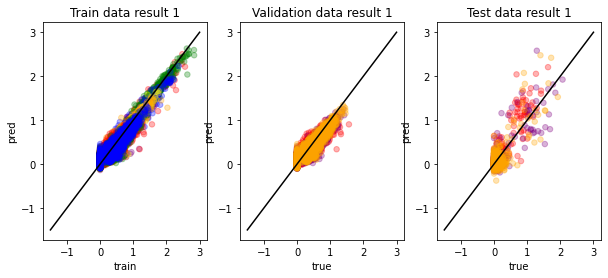

Epoch  13100 Train_loss:  0.089819595  Validation_loss:  0.09767485  Test_loss:  0.22203763
Epoch  13200 Train_loss:  0.08920999  Validation_loss:  0.09703099  Test_loss:  0.22256793
Epoch  13300 Train_loss:  0.08860504  Validation_loss:  0.09638962  Test_loss:  0.22307003
Epoch  13400 Train_loss:  0.08793827  Validation_loss:  0.09572471  Test_loss:  0.22359417
Epoch  13500 Train_loss:  0.08735923  Validation_loss:  0.095104106  Test_loss:  0.22383459
Epoch  13600 Train_loss:  0.08690398  Validation_loss:  0.09456959  Test_loss:  0.22358632
Epoch  13700 Train_loss:  0.0861639  Validation_loss:  0.09388339  Test_loss:  0.22504015
Epoch  13800 Train_loss:  0.0857072  Validation_loss:  0.09333791  Test_loss:  0.22460325
Epoch  13900 Train_loss:  0.0851531  Validation_loss:  0.09274883  Test_loss:  0.225026
Epoch  14000 Train_loss:  0.08458936  Validation_loss:  0.09213638  Test_loss:  0.22480024


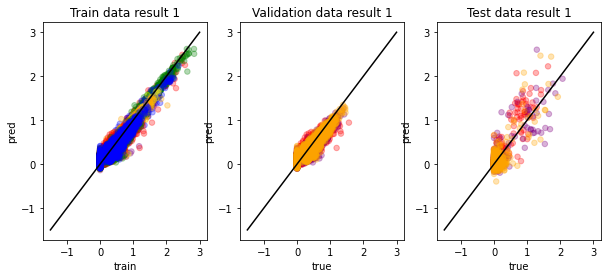

Epoch  14100 Train_loss:  0.08409988  Validation_loss:  0.091607966  Test_loss:  0.22467397
Epoch  14200 Train_loss:  0.08342648  Validation_loss:  0.090973854  Test_loss:  0.22582364
Epoch  14300 Train_loss:  0.08296513  Validation_loss:  0.09043203  Test_loss:  0.22570807
Epoch  14400 Train_loss:  0.08244636  Validation_loss:  0.08984778  Test_loss:  0.2254553
Epoch  14500 Train_loss:  0.08184089  Validation_loss:  0.089258775  Test_loss:  0.22616306
Epoch  14600 Train_loss:  0.081329815  Validation_loss:  0.08870121  Test_loss:  0.22634017
Epoch  14700 Train_loss:  0.08078961  Validation_loss:  0.08814269  Test_loss:  0.22676222
Epoch  14800 Train_loss:  0.080335155  Validation_loss:  0.08762508  Test_loss:  0.22635049
Epoch  14900 Train_loss:  0.07994595  Validation_loss:  0.08717059  Test_loss:  0.22608452
Epoch  15000 Train_loss:  0.07944739  Validation_loss:  0.08661541  Test_loss:  0.22616883


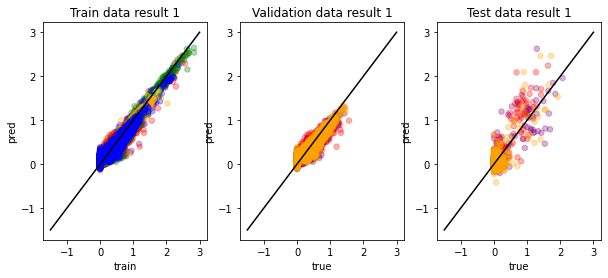

Epoch  15100 Train_loss:  0.07873619  Validation_loss:  0.08597269  Test_loss:  0.22789203
Epoch  15200 Train_loss:  0.07845954  Validation_loss:  0.085570894  Test_loss:  0.22653075
Epoch  15300 Train_loss:  0.07783095  Validation_loss:  0.08493989  Test_loss:  0.22753061
Epoch  15400 Train_loss:  0.07742175  Validation_loss:  0.08447801  Test_loss:  0.22701438
Epoch  15500 Train_loss:  0.07688563  Validation_loss:  0.08392024  Test_loss:  0.22752796
Epoch  15600 Train_loss:  0.076382086  Validation_loss:  0.08340546  Test_loss:  0.22831252
Epoch  15700 Train_loss:  0.07590738  Validation_loss:  0.08289273  Test_loss:  0.22813407
Epoch  15800 Train_loss:  0.07550842  Validation_loss:  0.08244467  Test_loss:  0.22807737
Epoch  15900 Train_loss:  0.07511527  Validation_loss:  0.081981175  Test_loss:  0.22794864
Epoch  16000 Train_loss:  0.07461818  Validation_loss:  0.081472345  Test_loss:  0.22822323


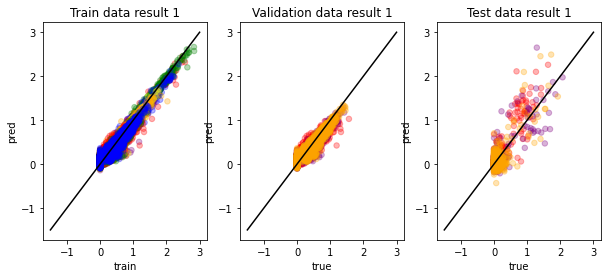

Epoch  16100 Train_loss:  0.0741027  Validation_loss:  0.08093608  Test_loss:  0.22893034
Epoch  16200 Train_loss:  0.07380559  Validation_loss:  0.08058914  Test_loss:  0.2281112
Epoch  16300 Train_loss:  0.07339687  Validation_loss:  0.08011804  Test_loss:  0.22828102
Epoch  16400 Train_loss:  0.072792634  Validation_loss:  0.07953305  Test_loss:  0.22916682
Epoch  16500 Train_loss:  0.0722971  Validation_loss:  0.07902474  Test_loss:  0.22961833
Epoch  16600 Train_loss:  0.07196352  Validation_loss:  0.0786117  Test_loss:  0.22919208
Epoch  16700 Train_loss:  0.07149705  Validation_loss:  0.07812582  Test_loss:  0.22961852
Epoch  16800 Train_loss:  0.07126292  Validation_loss:  0.07777983  Test_loss:  0.22892423
Epoch  16900 Train_loss:  0.07071331  Validation_loss:  0.07725016  Test_loss:  0.22941743
Epoch  17000 Train_loss:  0.07030227  Validation_loss:  0.07680573  Test_loss:  0.22974357


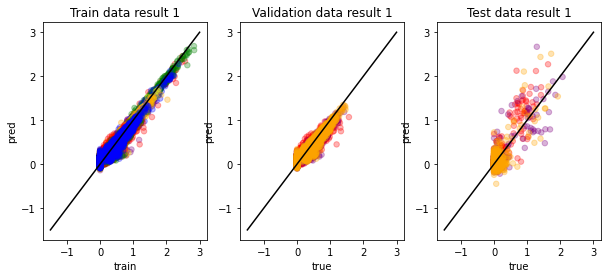

Epoch  17100 Train_loss:  0.06974871  Validation_loss:  0.076272234  Test_loss:  0.2304296
Epoch  17200 Train_loss:  0.06936445  Validation_loss:  0.07586069  Test_loss:  0.23051511
Epoch  17300 Train_loss:  0.06897069  Validation_loss:  0.07545076  Test_loss:  0.23110269
Epoch  17400 Train_loss:  0.06864535  Validation_loss:  0.075060256  Test_loss:  0.23060998
Epoch  17500 Train_loss:  0.068207026  Validation_loss:  0.07461919  Test_loss:  0.23106666
Epoch  17600 Train_loss:  0.06774112  Validation_loss:  0.07414653  Test_loss:  0.231675
Epoch  17700 Train_loss:  0.06739608  Validation_loss:  0.07374002  Test_loss:  0.23126327
Epoch  17800 Train_loss:  0.06703281  Validation_loss:  0.073327005  Test_loss:  0.23126525
Epoch  17900 Train_loss:  0.06686533  Validation_loss:  0.07309834  Test_loss:  0.23077704
Epoch  18000 Train_loss:  0.06623708  Validation_loss:  0.072500974  Test_loss:  0.23189774


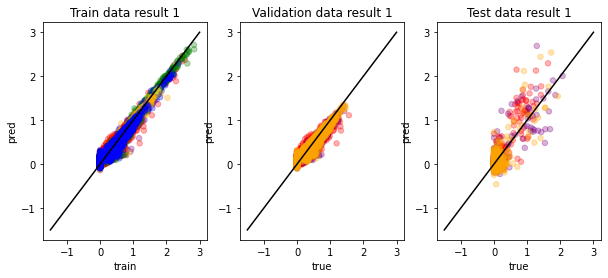

Epoch  18100 Train_loss:  0.06607135  Validation_loss:  0.07224144  Test_loss:  0.23120326
Epoch  18200 Train_loss:  0.06554093  Validation_loss:  0.07170926  Test_loss:  0.2319157
Epoch  18300 Train_loss:  0.06511945  Validation_loss:  0.071299195  Test_loss:  0.23251222
Epoch  18400 Train_loss:  0.06492225  Validation_loss:  0.07100735  Test_loss:  0.23191084


KeyboardInterrupt: 

In [40]:
num_epochs = 20000
learning_rate = 0.001
latent_dim = 50
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
# model.load_state_dict(torch.load('Batch_feature_norm_model'))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
train_pred_np, train_output_np, val_pred_np, val_output_np = fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output, test_input, test_output)

Autoencoder(
  (linear1): Linear(in_features=13953, out_features=15, bias=True)
  (linear2): Linear(in_features=6976, out_features=3488, bias=True)
  (linear3): Linear(in_features=3488, out_features=1744, bias=True)
  (linear4): Linear(in_features=1744, out_features=872, bias=True)
  (linear5): Linear(in_features=15, out_features=1, bias=True)
  (relu): ReLU()
  (leakyrelu): LeakyReLU(negative_slope=0.1)
  (dropout): Dropout(p=0.15, inplace=False)
  (linear): Linear(in_features=13953, out_features=1, bias=True)
)
Epoch  0 Train_loss:  0.3310312  Validation_loss:  0.27647877  Test_loss:  0.3257646


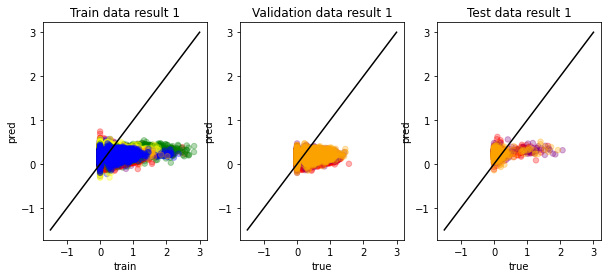

Epoch  100 Train_loss:  0.21605863  Validation_loss:  0.21436244  Test_loss:  0.19690375
Epoch  200 Train_loss:  0.2073375  Validation_loss:  0.20671162  Test_loss:  0.18547027
Epoch  300 Train_loss:  0.20260742  Validation_loss:  0.2027017  Test_loss:  0.17853492
Epoch  400 Train_loss:  0.19972524  Validation_loss:  0.2002594  Test_loss:  0.17425767
Epoch  500 Train_loss:  0.197429  Validation_loss:  0.19847248  Test_loss:  0.1711949
Epoch  600 Train_loss:  0.19543517  Validation_loss:  0.19699706  Test_loss:  0.16916686
Epoch  700 Train_loss:  0.19379598  Validation_loss:  0.19575426  Test_loss:  0.1677891
Epoch  800 Train_loss:  0.19227678  Validation_loss:  0.19462252  Test_loss:  0.16696024
Epoch  900 Train_loss:  0.19094782  Validation_loss:  0.1936297  Test_loss:  0.16635469
Epoch  1000 Train_loss:  0.18963797  Validation_loss:  0.19268659  Test_loss:  0.16614059


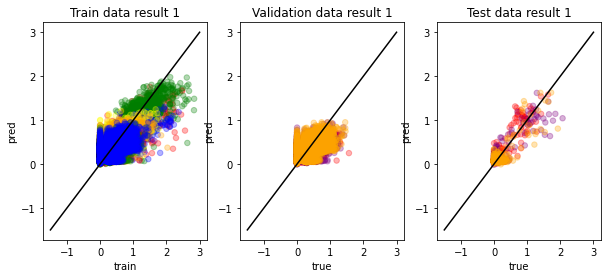

Epoch  1100 Train_loss:  0.18854088  Validation_loss:  0.19186273  Test_loss:  0.16571826
Epoch  1200 Train_loss:  0.18734115  Validation_loss:  0.19100285  Test_loss:  0.1656496
Epoch  1300 Train_loss:  0.18630502  Validation_loss:  0.19024074  Test_loss:  0.1656305
Epoch  1400 Train_loss:  0.18523645  Validation_loss:  0.18946481  Test_loss:  0.16581172
Epoch  1500 Train_loss:  0.18431467  Validation_loss:  0.18872522  Test_loss:  0.16575105
Epoch  1600 Train_loss:  0.18330562  Validation_loss:  0.18800308  Test_loss:  0.16598898
Epoch  1700 Train_loss:  0.18240643  Validation_loss:  0.18731344  Test_loss:  0.16606466
Epoch  1800 Train_loss:  0.18152045  Validation_loss:  0.18664645  Test_loss:  0.16629241
Epoch  1900 Train_loss:  0.18063582  Validation_loss:  0.18597282  Test_loss:  0.16660346
Epoch  2000 Train_loss:  0.1798188  Validation_loss:  0.18533057  Test_loss:  0.16670758


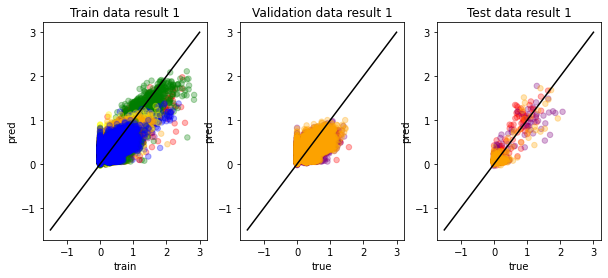

KeyboardInterrupt: 

In [44]:
num_epochs = 2000
learning_rate = 0.001
latent_dim = 15
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
print(model)
# model.load_state_dict(torch.load('Batch_feature_norm_model'))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
train_pred_np, train_output_np, val_pred_np, val_output_np = fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output, test_input, test_output)

Autoencoder(
  (linear1): Linear(in_features=13953, out_features=10, bias=True)
  (linear2): Linear(in_features=6976, out_features=3488, bias=True)
  (linear3): Linear(in_features=3488, out_features=1744, bias=True)
  (linear4): Linear(in_features=1744, out_features=872, bias=True)
  (linear5): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
  (leakyrelu): LeakyReLU(negative_slope=0.1)
  (dropout): Dropout(p=0.15, inplace=False)
  (linear): Linear(in_features=13953, out_features=1, bias=True)
)
Epoch  0 Train_loss:  0.3895034  Validation_loss:  0.354962  Test_loss:  0.3373567


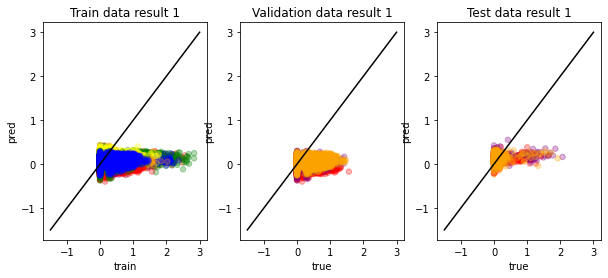

Epoch  100 Train_loss:  0.22090961  Validation_loss:  0.21832791  Test_loss:  0.19932039
Epoch  200 Train_loss:  0.20983714  Validation_loss:  0.2075268  Test_loss:  0.18515371
Epoch  300 Train_loss:  0.20397905  Validation_loss:  0.2028335  Test_loss:  0.17667903
Epoch  400 Train_loss:  0.20058279  Validation_loss:  0.20020528  Test_loss:  0.17248888
Epoch  500 Train_loss:  0.19847308  Validation_loss:  0.19854066  Test_loss:  0.16965503
Epoch  600 Train_loss:  0.19656496  Validation_loss:  0.19714661  Test_loss:  0.16791889
Epoch  700 Train_loss:  0.19505803  Validation_loss:  0.19604567  Test_loss:  0.16683915
Epoch  800 Train_loss:  0.19378044  Validation_loss:  0.19507319  Test_loss:  0.16593668
Epoch  900 Train_loss:  0.19243917  Validation_loss:  0.19409397  Test_loss:  0.16540009
Epoch  1000 Train_loss:  0.19137938  Validation_loss:  0.19327663  Test_loss:  0.16474907


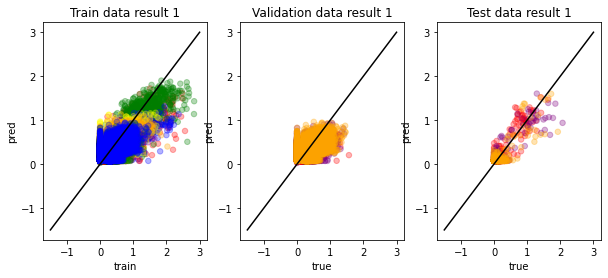

Epoch  1100 Train_loss:  0.19009238  Validation_loss:  0.19237049  Test_loss:  0.16450845
Epoch  1200 Train_loss:  0.18901172  Validation_loss:  0.19153325  Test_loss:  0.16414404
Epoch  1300 Train_loss:  0.18809849  Validation_loss:  0.19083135  Test_loss:  0.1638618
Epoch  1400 Train_loss:  0.18707117  Validation_loss:  0.19004747  Test_loss:  0.16377424
Epoch  1500 Train_loss:  0.18608087  Validation_loss:  0.18933862  Test_loss:  0.16382845
Epoch  1600 Train_loss:  0.18516703  Validation_loss:  0.18863876  Test_loss:  0.16377127
Epoch  1700 Train_loss:  0.18434656  Validation_loss:  0.18796936  Test_loss:  0.16368102
Epoch  1800 Train_loss:  0.18350416  Validation_loss:  0.18733604  Test_loss:  0.16369106
Epoch  1900 Train_loss:  0.1827012  Validation_loss:  0.18671487  Test_loss:  0.16390294


In [45]:
num_epochs = 2000
learning_rate = 0.001
latent_dim = 10
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
print(model)
# model.load_state_dict(torch.load('Batch_feature_norm_model'))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
train_pred_np, train_output_np, val_pred_np, val_output_np = fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output, test_input, test_output)

Autoencoder(
  (linear1): Linear(in_features=13953, out_features=25, bias=True)
  (linear2): Linear(in_features=6976, out_features=3488, bias=True)
  (linear3): Linear(in_features=3488, out_features=1744, bias=True)
  (linear4): Linear(in_features=1744, out_features=872, bias=True)
  (linear5): Linear(in_features=25, out_features=1, bias=True)
  (relu): ReLU()
  (leakyrelu): LeakyReLU(negative_slope=0.1)
  (dropout): Dropout(p=0.15, inplace=False)
  (linear): Linear(in_features=13953, out_features=1, bias=True)
)
Epoch  0 Train_loss:  0.3651171  Validation_loss:  0.31276533  Test_loss:  0.35035872


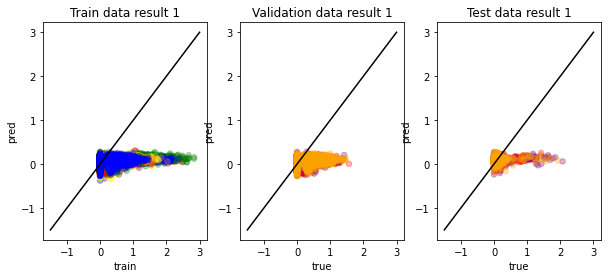

Epoch  100 Train_loss:  0.22099884  Validation_loss:  0.21626592  Test_loss:  0.20155872
Epoch  200 Train_loss:  0.21096203  Validation_loss:  0.20883074  Test_loss:  0.18728375
Epoch  300 Train_loss:  0.20537005  Validation_loss:  0.20481665  Test_loss:  0.1796151
Epoch  400 Train_loss:  0.20166883  Validation_loss:  0.20215161  Test_loss:  0.1749814
Epoch  500 Train_loss:  0.19901405  Validation_loss:  0.20008427  Test_loss:  0.17237179
Epoch  600 Train_loss:  0.19690533  Validation_loss:  0.19834772  Test_loss:  0.17076217
Epoch  700 Train_loss:  0.19511172  Validation_loss:  0.19698054  Test_loss:  0.16979948
Epoch  800 Train_loss:  0.19356579  Validation_loss:  0.19577998  Test_loss:  0.16903211
Epoch  900 Train_loss:  0.19220813  Validation_loss:  0.1947495  Test_loss:  0.16858374
Epoch  1000 Train_loss:  0.19098788  Validation_loss:  0.19384326  Test_loss:  0.16801487


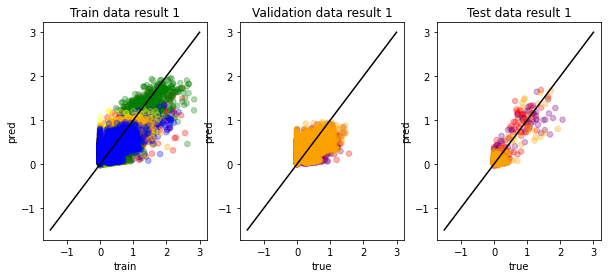

Epoch  1100 Train_loss:  0.18977961  Validation_loss:  0.19297637  Test_loss:  0.16792421
Epoch  1200 Train_loss:  0.18866862  Validation_loss:  0.19219682  Test_loss:  0.16776775
Epoch  1300 Train_loss:  0.1876377  Validation_loss:  0.19143121  Test_loss:  0.16747548
Epoch  1400 Train_loss:  0.18659244  Validation_loss:  0.19069473  Test_loss:  0.16766784
Epoch  1500 Train_loss:  0.18565272  Validation_loss:  0.18999992  Test_loss:  0.16724864
Epoch  1600 Train_loss:  0.18465088  Validation_loss:  0.18929319  Test_loss:  0.16758677
Epoch  1700 Train_loss:  0.18368213  Validation_loss:  0.18860541  Test_loss:  0.16771115
Epoch  1800 Train_loss:  0.18276617  Validation_loss:  0.18793857  Test_loss:  0.1679511
Epoch  1900 Train_loss:  0.18191837  Validation_loss:  0.18726316  Test_loss:  0.16773193


In [46]:
num_epochs = 2000
learning_rate = 0.001
latent_dim = 25
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
print(model)
# model.load_state_dict(torch.load('Batch_feature_norm_model'))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
train_pred_np, train_output_np, val_pred_np, val_output_np = fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output, test_input, test_output)

Autoencoder(
  (linear1): Linear(in_features=13953, out_features=5, bias=True)
  (linear2): Linear(in_features=6976, out_features=3488, bias=True)
  (linear3): Linear(in_features=3488, out_features=1744, bias=True)
  (linear4): Linear(in_features=1744, out_features=872, bias=True)
  (linear5): Linear(in_features=5, out_features=1, bias=True)
  (relu): ReLU()
  (leakyrelu): LeakyReLU(negative_slope=0.1)
  (dropout): Dropout(p=0.15, inplace=False)
  (linear): Linear(in_features=13953, out_features=1, bias=True)
)
Epoch  0 Train_loss:  0.35718256  Validation_loss:  0.2982859  Test_loss:  0.34395


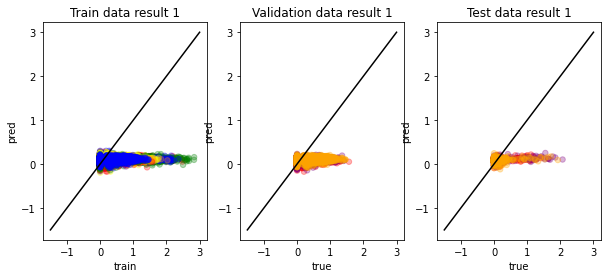

Epoch  100 Train_loss:  0.22678639  Validation_loss:  0.21525027  Test_loss:  0.21023044
Epoch  200 Train_loss:  0.21645245  Validation_loss:  0.21034656  Test_loss:  0.19457552
Epoch  300 Train_loss:  0.21025184  Validation_loss:  0.20662463  Test_loss:  0.18527496
Epoch  400 Train_loss:  0.20621979  Validation_loss:  0.20389259  Test_loss:  0.17979358
Epoch  500 Train_loss:  0.20337923  Validation_loss:  0.20194995  Test_loss:  0.17674685
Epoch  600 Train_loss:  0.20137346  Validation_loss:  0.2005472  Test_loss:  0.17479147
Epoch  700 Train_loss:  0.19936213  Validation_loss:  0.19908664  Test_loss:  0.17323165
Epoch  800 Train_loss:  0.1978791  Validation_loss:  0.1980068  Test_loss:  0.17215277
Epoch  900 Train_loss:  0.19648272  Validation_loss:  0.19697024  Test_loss:  0.17142509
Epoch  1000 Train_loss:  0.19518022  Validation_loss:  0.19598521  Test_loss:  0.1708022


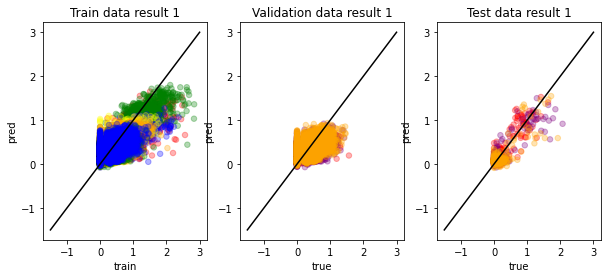

Epoch  1100 Train_loss:  0.19403687  Validation_loss:  0.19513312  Test_loss:  0.17023572
Epoch  1200 Train_loss:  0.19305103  Validation_loss:  0.19438286  Test_loss:  0.16976425
Epoch  1300 Train_loss:  0.19188154  Validation_loss:  0.19351792  Test_loss:  0.16949612
Epoch  1400 Train_loss:  0.19115177  Validation_loss:  0.19292904  Test_loss:  0.16902967
Epoch  1500 Train_loss:  0.19012666  Validation_loss:  0.1921406  Test_loss:  0.16880201
Epoch  1600 Train_loss:  0.18917216  Validation_loss:  0.19143286  Test_loss:  0.16853496
Epoch  1700 Train_loss:  0.18816535  Validation_loss:  0.19071238  Test_loss:  0.16855368
Epoch  1800 Train_loss:  0.18749304  Validation_loss:  0.19013628  Test_loss:  0.16831155
Epoch  1900 Train_loss:  0.1866093  Validation_loss:  0.18945906  Test_loss:  0.1682534


In [47]:
num_epochs = 2000
learning_rate = 0.001
latent_dim = 5
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
print(model)
# model.load_state_dict(torch.load('Batch_feature_norm_model'))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
train_pred_np, train_output_np, val_pred_np, val_output_np = fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output, test_input, test_output)